# Imports

In [101]:
from pathlib import Path
import pandas as pd
from xml.etree import ElementTree as ET
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import re



DATA_ROOT = Path("KWS")

# Load the .tsv files and build a word table

In [102]:
# 1) Load transcription table: word_id -> transcription
trans_df = pd.read_csv(
    DATA_ROOT / "transcription.tsv",
    sep="\t",
    header=None,
    names=["word_id", "transcription"],
    dtype=str,
)

print("Transcriptions:")
print(trans_df.head())

# 2) Load train / validation document lists
train_docs = pd.read_csv(
    DATA_ROOT / "train.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

val_docs = pd.read_csv(
    DATA_ROOT / "validation.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

train_doc_set = set(train_docs["doc_id"])
val_doc_set = set(val_docs["doc_id"])

print("Number of train docs:", len(train_doc_set))
print("Number of val docs:", len(val_doc_set))

# 3) Split word_id into (doc, line, word)
def split_word_id(word_id: str):
    """
    Split an ID like '270-05-07' into (doc_id, line_id, word_idx).
     Args:
        word_id (str): Word ID in the format 'doc-line-word'.
     Returns:
        tuple: (doc_id, line_id, word_idx)
    """
    doc, line, word = word_id.split("-")
    return doc, line, word

words_df = trans_df.copy()
words_df[["doc_id", "line_id", "word_idx"]] = (
    words_df["word_id"]
    .apply(split_word_id)
    .apply(pd.Series)
)

# 4) Assign split based on document id
def get_split(doc_id: str) -> str:
    """
    Determine the data split for a given document ID.
     Args:
        doc_id (str): Document ID.
     Returns:
        str: "train", "val", or "unknown".
    """
    if doc_id in train_doc_set:
        return "train"
    elif doc_id in val_doc_set:
        return "val"
    else:
        return "unknown"

words_df["split"] = words_df["doc_id"].apply(get_split)

print("\nWords DataFrame:")
print(words_df.head())
print("\nSplit value counts:")
print(words_df["split"].value_counts())


Transcriptions:
     word_id                 transcription
0  270-01-01              s_2-s_7-s_0-s_pt
1  270-01-02            L-e-t-t-e-r-s-s_cm
2  270-01-03                   O-r-d-e-r-s
3  270-01-04                         a-n-d
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt
Number of train docs: 10
Number of val docs: 5

Words DataFrame:
     word_id                 transcription doc_id line_id word_idx  split
0  270-01-01              s_2-s_7-s_0-s_pt    270      01       01  train
1  270-01-02            L-e-t-t-e-r-s-s_cm    270      01       02  train
2  270-01-03                   O-r-d-e-r-s    270      01       03  train
3  270-01-04                         a-n-d    270      01       04  train
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt    270      01       05  train

Split value counts:
split
train    2433
val      1293
Name: count, dtype: int64


# Extract images of words

## Path

In [103]:
IMAGES_DIR = DATA_ROOT / "images"
LOCATIONS_DIR = DATA_ROOT / "locations"

## Find the page image and SVG for a document

In [104]:
def find_page_image(doc_id: str) -> Image.Image:
    """
    Return the PIL image for a given document id.

    Args:
        doc_id (str): Document identifier, e.g. "270".

    Returns:
        Image.Image: Grayscale page image.
    """
    exts = ("png", "jpg", "jpeg", "tif", "tiff", "bmp")
    for ext in exts:
        candidates = list(IMAGES_DIR.glob(f"*{doc_id}*.{ext}"))
        if candidates:
            img_path = candidates[0]
            return Image.open(img_path).convert("L")  # grayscale
    raise FileNotFoundError(f"No page image found for doc_id={doc_id!r}")


def find_svg_for_doc(doc_id: str) -> Path:
    """
    Return the SVG file path for a given document id.

    Args:
        doc_id (str): Document identifier, e.g. "270".

    Returns:
        Path: Path to the SVG file.
    """
    candidates = list(LOCATIONS_DIR.glob(f"*{doc_id}*.svg"))
    if not candidates:
        raise FileNotFoundError(f"No SVG found for doc_id={doc_id!r}")
    if len(candidates) > 1:
        print(f"Warning: multiple SVGs for doc {doc_id}, using {candidates[0].name}")
    return candidates[0]


## Retrieve the polygon of a word in SVG

In [105]:
def get_word_polygon(doc_id: str, word_id: str):
    """
    Parse the SVG for a given document and extract polygon points for a word.

    Each word is a <path> element with:
        id="DDD-LL-WW"
        d="M x y L x y L x y ... Z"

    Args:
        doc_id (str): Document id, e.g. "270".
        word_id (str): Word id, e.g. "270-05-07".

    Returns:
        list(tuple[float, float]): List of (x, y) polygon points.
    """
    svg_path = find_svg_for_doc(doc_id)
    tree = ET.parse(svg_path)
    root = tree.getroot()

    target_elem = None
    for elem in root.iter():
        if elem.attrib.get("id") == word_id:
            target_elem = elem
            break

    if target_elem is None:
        raise ValueError(f"Word id {word_id!r} not found in {svg_path.name}")

    d = target_elem.attrib.get("d")
    if d is None:
        print(f"[DEBUG] Element for {word_id!r} in {svg_path.name}:")
        print("  tag:", target_elem.tag)
        print("  attrib:", target_elem.attrib)
        raise ValueError(f"No 'd' attribute for word {word_id!r} (expected <path d='...'>)")

    # Extract all numbers in d (ignore M/L/Z etc.)
    nums = re.findall(r"[-+]?\d*\.?\d+", d)
    if len(nums) < 4:
        raise ValueError(f"Not enough coordinates in path 'd' for word {word_id!r}")

    coords = list(map(float, nums))
    # Group as (x1, y1), (x2, y2), ...
    pts = list(zip(coords[0::2], coords[1::2]))
    return pts

## Cropping the word image from the polygon

In [106]:
def crop_word_image(page_img: Image.Image, polygon, padding: int = 2) -> Image.Image:
    """
    Crop a word image from the page given its polygon.

    Args:
        page_img (Image.Image): Full page (grayscale) image.
        polygon (list[tuple[float, float]]): List of (x, y) coordinates defining the word polygon.
        padding (int): Extra pixels to extend the bounding box on each side.

    Returns:
        Image.Image: Cropped word image.
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]

    left = max(int(min(xs)) - padding, 0)
    right = min(int(max(xs)) + padding, page_img.width)
    top = max(int(min(ys)) - padding, 0)
    bottom = min(int(max(ys)) + padding, page_img.height)

    return page_img.crop((left, top, right, bottom))


## Obtain the image of a word

In [107]:
def get_word_image(word_row, padding: int = 2) -> Image.Image:
    """
    Convenience function: from a row of words_df, return the cropped word image.

    Args:
        word_row (pandas.Series):Row from words_df with fields 'word_id' and 'doc_id'.
        padding (int): Extra pixels around the bounding box.

    Returns:
        Image.Image: Cropped word image.
    """
    doc_id = word_row["doc_id"]
    word_id = word_row["word_id"]

    page_img = find_page_image(doc_id)
    polygon = get_word_polygon(doc_id, word_id)
    word_img = crop_word_image(page_img, polygon, padding=padding)
    return word_img


## Tests

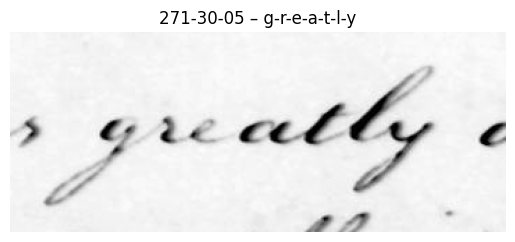

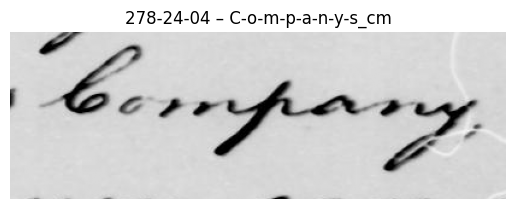

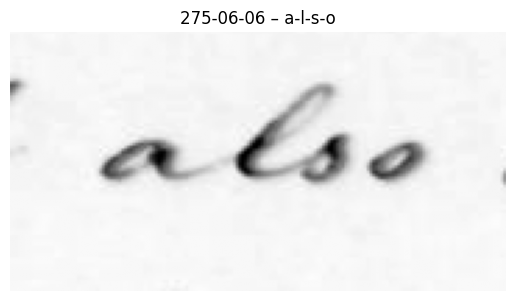

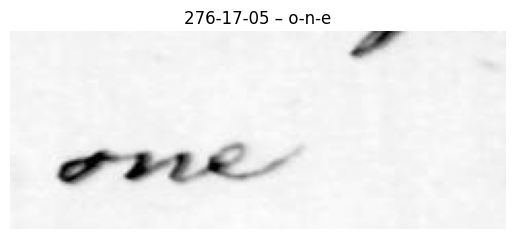

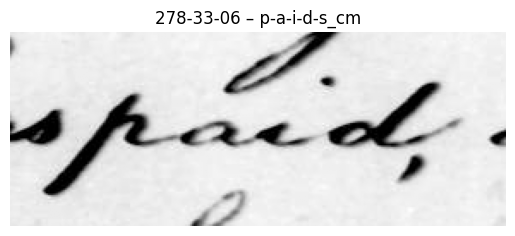

In [108]:

# Pick a few random words from training set
sample_rows = words_df[words_df["split"] == "train"].sample(5, random_state=3)

for _, row in sample_rows.iterrows():
    img = get_word_image(row, padding=3)
    plt.figure()
    plt.title(f"{row['word_id']} – {row['transcription']}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")


# PART 2

### Convert a word image to grayscale, normalize its height, and return a 2D float32 array in [0, 1].

In [109]:
from PIL import Image
import numpy as np

def preprocess_word_image(img, target_height: int = 32) -> np.ndarray:
    """
    img : PIL.Image.Image or np.ndarray --> Raw word image.
    target_height : int --> Desired output height in pixels.
    """
    # Ensure PIL image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    # Grayscale
    img = img.convert("L")  # 0–255

    # Resize to fixed height, keep aspect ratio
    w, h = img.size
    if h == 0:
        raise ValueError("Image has zero height")
    new_h = target_height
    new_w = int(round(w * new_h / h))
    img = img.resize((new_w, new_h), Image.BILINEAR)

    # To numpy float32 in [0, 1]
    arr = np.asarray(img, dtype=np.float32) / 255.
    return arr


### Compute a feature vector for a single vertical window of a word image

In [110]:
def extract_window_features(
    window: np.ndarray,
    bin_thresh: float = 0.5
) -> np.ndarray:

    H, W = window.shape

    # Binarize (ink=1, background=0)
    bin_win = (window < bin_thresh).astype(np.float32)

    # Global ink density
    ink_density = bin_win.mean()

    # Split vertically in 3 stripes: top, middle, bottom
    h3 = H // 3 if H >= 3 else 1
    top    = bin_win[:h3, :]
    middle = bin_win[h3:2*h3, :]
    bottom = bin_win[2*h3:, :]

    top_density    = top.mean() if top.size > 0 else 0.0
    middle_density = middle.mean() if middle.size > 0 else 0.0
    bottom_density = bottom.mean() if bottom.size > 0 else 0.0

    # Average number of vertical transitions per column
    if H > 1:
        transitions_per_col = np.abs(np.diff(bin_win, axis=0)).sum(axis=0)
        mean_transitions = transitions_per_col.mean()
    else:
        mean_transitions = 0.0

    feat = np.array(
        [ink_density, top_density, middle_density, bottom_density, mean_transitions],
        dtype=np.float32
    )
    return feat


### Word image → séquence de features (sliding window)

Convert a word image to a sequence of feature vectors using a vertical sliding window.

In [111]:
def word_image_to_sequence(
    img,
    target_height: int = 32,
    window_width: int = 8,
    step: int = 4
) -> np.ndarray:

    """
    img : PIL.Image.Image or np.ndarray -->  Raw word image.
    target_height : int --> Desired height after preprocessing.
    window_width : int --> Width of the sliding window (pixels).
    step : int --> Horizontal step between windows (pixels).

    """
    arr = preprocess_word_image(img, target_height=target_height)
    H, W = arr.shape

    feats = []
    x = 0
    while x + window_width <= W:
        window = arr[:, x:x + window_width]
        f = extract_window_features(window)
        feats.append(f)
        x += step

    # If the word is too narrow, we take at least one window
    #Sequence of shape (T, d), where T is the number of windows and d is the feature dimension

    if not feats:
        window = arr
        feats.append(extract_window_features(window))

    seq = np.stack(feats, axis=0)  # (T, d)
    return seq


### Build feature sequences for each word in words_df
then store them in the global dict word_sequences

In [112]:
# Cache global : word_id -> np.ndarray(T, d)
word_sequences: dict[str, np.ndarray] = {}

def build_word_sequences(
    words_df,
    subset: str | None = None,
    target_height: int = 32,
    window_width: int = 8,
    step: int = 4
):

    global word_sequences
    word_sequences = {}

    if subset is not None:
        df = words_df[words_df["split"] == subset]
    else:
        df = words_df

    print(f"Building sequences for {len(df)} words (subset={subset})")

    for _, row in df.iterrows():
        img = get_word_image(row, padding=2)
        seq = word_image_to_sequence(
            img,
            target_height=target_height,
            window_width=window_width,
            step=step
        )
        word_sequences[row["word_id"]] = seq

    print("Done. Stored sequences for", len(word_sequences), "words.")


### Compute DTW distance between two sequences of feature vectors

In [113]:
def dtw_distance(
    seq1: np.ndarray, # (T1, d)
    seq2: np.ndarray, # (T2, d)
    band: int | None = None # int or None
) -> float:

    T1, d1 = seq1.shape
    T2, d2 = seq2.shape
    assert d1 == d2, "Feature dimensions must match"

    # Initialize cost matrix with +inf
    D = np.full((T1 + 1, T2 + 1), np.inf, dtype=np.float32)
    D[0, 0] = 0.0

    for i in range(1, T1 + 1):
        # Optional Sakoe-Chiba band
        j_start = 1
        j_end = T2 + 1
        if band is not None:
            j_start = max(1, i - band)
            j_end   = min(T2 + 1, i + band)

        for j in range(j_start, j_end):
            # Squared Euclidean distance between seq1[i-1] and seq2[j-1]
            diff = seq1[i - 1] - seq2[j - 1]
            cost = float(np.dot(diff, diff))

            # Classic DTW: three predecessors (diag, up, left)
            D[i, j] = cost + min(
                D[i - 1, j],    # insertion
                D[i, j - 1],    # deletion
                D[i - 1, j - 1] # match
            )

    return float(D[T1, T2])

# TEST

In [114]:
train_words = words_df[words_df["split"] == "train"]

# How many times does each transcription appear?
counts = train_words["transcription"].value_counts()
print(counts.head(20))  # just to take a look

# words that appear at least two times
repeated = counts[counts >= 2]
print("\nNumber of words with at least 2 occurrences :", len(repeated))



transcription
t-o              128
t-h-e            124
o-f               64
a-n-d             63
a-r-e             57
y-o-u             43
f-o-r             37
s_mi              34
b-e               29
Y-o-u             27
w-i-t-h           26
t-h-a-t           25
a-t               25
a-s               25
i-s               21
t-h-e-y           19
y-o-u-r           19
i-n               19
w-h-i-c-h         19
C-a-p-t-a-i-n     18
Name: count, dtype: int64

Number of words with at least 2 occurrences : 271


In [115]:
train_words = words_df[words_df["split"] == "train"]

# Transcriptions that appear at least two times
counts = train_words["transcription"].value_counts()
repeated = counts[counts >= 2]

if len(repeated) == 0:
    print("No transaction appear two times in train")
else:
    trans = repeated.index[0]
    same = train_words[train_words["transcription"] == trans]

    row_a = same.iloc[0]
    row_b = same.iloc[1]

    # to ensure you have the sequence
    def get_seq(row):
        wid = row["word_id"]
        if wid in word_sequences:
            return word_sequences[wid]
        else:
            img = get_word_image(row, padding=2)
            seq = word_image_to_sequence(img)
            word_sequences[wid] = seq
            return seq

    seq_a = get_seq(row_a)
    seq_b = get_seq(row_b)

    d_same = dtw_distance(seq_a, seq_b, band=10)
    print(f"Test transcription : {trans}")
    print("DTW distance (same word):", d_same)

    # to compare
    diff = train_words[train_words["transcription"] != trans]
    if len(diff) > 0:
        row_c = diff.iloc[0]
        seq_c = get_seq(row_c)
        d_diff = dtw_distance(seq_a, seq_c, band=10)
        print("DTW distance (different word):", d_diff)
    else:
        print("No word with different transcription to compare.")


Test transcription : t-o
DTW distance (same word): 17.274059295654297
DTW distance (different word): 45.87167739868164


In [ ]:
# Re-build feature sequences for the ENTIRE dataset Train + Validation

print("Building features for ALL data...")
build_word_sequences(words_df)

Building features for ALL data...
Building sequences for 3726 words (subset=None)


PART 3: RETRIEVAL AND EVALUATION


Load Keywords and Define Gallery

In [ ]:

# We will search for queries inside the 'train' split
gallery_df = words_df[words_df["split"] == "train"]
gallery_ids = gallery_df["word_id"].values

# 2. Load Keywords
try:
    keywords_df = pd.read_csv(
        DATA_ROOT / "keywords.tsv",
        sep="\t",
        header=None,
        names=["keyword"],
        dtype=str
    )
    print(f"Loaded {len(keywords_df)} keywords to spot.")
except FileNotFoundError:
    print("Warning: keywords.tsv not found. Using a manual list.")
    keywords_df = pd.DataFrame({"keyword": ["Orders", "government", "instructions", "letter"]})

print("First 5 keywords:", keywords_df["keyword"].head().tolist())

The Retrieval Function

In [ ]:
def retrieve_top_k(query_seq, gallery_ids, k=5, band=10):

    distances = []

    # Iterate over all training words
    for gid in gallery_ids:
        if gid not in word_sequences:
            continue

        gal_seq = word_sequences[gid]

        # Compute DTW distance
        dist = dtw_distance(query_seq, gal_seq, band=band)
        distances.append((gid, dist))

    # Sort by distance
    distances.sort(key=lambda x: x[1])

    return distances[:k]

Visualization Function

In [ ]:
def visualize_retrieval(query_row, top_matches):
    """
    Plot the query image and the top k retrieved images.
    """
    k = len(top_matches)
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 3))

    # 1. Plot Query
    query_img = get_word_image(query_row)
    axes[0].imshow(query_img, cmap="gray")
    axes[0].set_title(f"QUERY:\n{query_row['transcription']}")
    axes[0].axis("off")

    # 2. Plot Matches
    for i, (wid, dist) in enumerate(top_matches):
        match_row = words_df[words_df["word_id"] == wid].iloc[0]
        match_img = get_word_image(match_row)

        # Color title green if correct, red if wrong
        is_correct = (match_row['transcription'] == query_row['transcription'])
        color = "green" if is_correct else "red"

        axes[i+1].imshow(match_img, cmap="gray")
        axes[i+1].set_title(f"#{i+1} (d={dist:.1f})\n{match_row['transcription']}", color=color)
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()

Run the Evaluation Loop

In [ ]:
import random

# Settings
TOP_K = 5
NUM_KEYWORDS_TO_TEST = 3  # Limit to 3 keywords to save time during testing

print(f"--- Starting Evaluation on {NUM_KEYWORDS_TO_TEST} random keywords ---")

# Filter keywords that actually exist in our validation set
valid_keywords = []
val_df = words_df[words_df["split"] == "val"]

for kw in keywords_df["keyword"]:
    if not val_df[val_df["transcription"] == kw].empty:
        valid_keywords.append(kw)

# Pick random keywords to test
test_keywords = random.sample(valid_keywords, min(len(valid_keywords), NUM_KEYWORDS_TO_TEST))

total_precision = 0

for kw in test_keywords:
    print(f"\nSpotting Keyword: '{kw}'")

    # 1. Get a query image instance from the VALIDATION set
    query_candidates = val_df[val_df["transcription"] == kw]
    query_row = query_candidates.iloc[0] # Pick the first occurrence as our query

    # 2. Get the feature sequence
    if query_row["word_id"] not in word_sequences:
        print("Feature sequence missing, skipping...")
        continue
    query_seq = word_sequences[query_row["word_id"]]

    # 3. Run Retrieval
    top_matches = retrieve_top_k(query_seq, gallery_ids, k=TOP_K, band=10)

    # 4. Calculate Precision
    correct_count = 0
    for wid, dist in top_matches:
        trans = words_df[words_df["word_id"] == wid].iloc[0]["transcription"]
        if trans == kw:
            correct_count += 1

    precision = correct_count / TOP_K
    total_precision += precision
    print(f"Precision@{TOP_K}: {precision:.2f} ({correct_count}/{TOP_K} correct)")

    # 5. Visualize
    visualize_retrieval(query_row, top_matches)

print("-" * 30)
print(f"Average Precision@{TOP_K} over {len(test_keywords)} queries: {total_precision / len(test_keywords):.2f}")